# Data simulation


The following code was modified based on the simulation method described in the paper:

PASTE: Ron Zeira, Max Land, Alexander Strzalkowski, and Benjamin J. Raphael. "Alignment and integration of spatial transcriptomics data". Nature Methods (2022). https://doi.org/10.1038/s41592-022-01459-6

In [54]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scipy
import os
import os.path as osp
mpl.rcParams['pdf.fonttype'] = 42 # for pdf to be editable 

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)

/tmp/ipykernel_230457/3288172430.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-dark')


## Simulate Spatial Noise

# Define Simulation functions

Generate grid points 

Takes a DLPFC slice, rotates by angle. Next, we map all new coordinates to closest grid points.

This removes some points as some points move out from the grid or two points who share the same closest grid points will map to same coordinate.

In [55]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    print(f"The number of the original spots {len(spots):.2f}")
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]
    #print(len(new_spots))

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)
    print(f"The number of new spots {len(mapping):.2f}")
    if plot:
        fig = plt.figure(figsize=figsize) #s=100
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=50, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=50, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=50, marker=".",color='green')
        # plt.show()

    return new_spots,mapping


#Generate points that are aligned in alternating rows in grid for DLPFC data
def generate_offset_grid(rows, cols, spacing, offset, x_range, y_range):
    grid = []
    for row in range(rows):
        for col in range(cols):
            x = x_range[0] + col * spacing*2+ (row % 2) * spacing
            y = y_range[0] +row * offset
            grid.append([x, y])
    return grid

def euclidean_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def minimal_internal_space(points):
    min_distance = float('inf')  # Initialize with a large value
    n = len(points)

    for i in range(n):
        for j in range(i + 1, n):
            distance = euclidean_distance(points[i], points[j])
            min_distance = min(min_distance, distance)

    return min_distance

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    min_space = minimal_internal_space(adata.obsm['spatial'])
    print(f"The minimal internal space between any two adjacent points is {min_space:.2f}")

    # generate grid
    x_coordinates = adata.obsm['spatial'][:, 0]  # Assuming x is in the first column
    y_coordinates = adata.obsm['spatial'][:, 1]  # Assuming y is in the second column
    min_x = np.min(x_coordinates)
    min_y = np.min(y_coordinates)
    max_x = np.max(x_coordinates)
    max_y = np.max(y_coordinates)   
    # print(min_x)
    # print(max_x)
    # print(min_y)
    # print(max_y)
    x_range = [min_x, max_x]
    y_range = [min_y, max_y]
    spacing = min_space/2 # this is the half of the distance between any two adjacent grid points
    offset = min_space*math.sqrt(3)/2 # this is the y coordinate difference between any two verticallly adjacent points
    rows = round((y_range[1]-y_range[0])/offset)+1 
    cols = round((x_range[1]-x_range[0])/(spacing*2))+1  
    grid = generate_offset_grid(rows, cols, spacing, offset, x_range, y_range)
    layer_grid = np.array(grid)
    #print(adata_sim.obsm['spatial'])
    #print(layer_grid)

    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=0, theta= rotation_angle, plot=False)
    adata_sim.obsm['spatial'] = new_spots

    return adata_sim[mappings, :], mappings

## Simulate Gene Expression

In [56]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds pertubations to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    # for large dataset
    df = pd.DataFrame(adata_sim.X.toarray())

    # for small dataset
    #df = pd.DataFrame(adata_sim.X)
    
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

Output simulated data

In [57]:

def simulate_out(adata_layer, pseudocounts, slice_name, output):   
    #adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/17.5) #% 80%
    #adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/10.3) #60%
    #adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/6.8) #40%
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/4.7) #20%
    #adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/17.5) #% 80%

    decimal_format = '{:.6f}' 
 
    mm = round(adata_layer_sim_spatial.shape[0]/adata_layer.shape[0]*100)
    print(f"We keep {mm}% of the original spots")
    np.save(osp.join(output, slice_name+f'_overlap={mm}%'+'mappings'), mappings)
    adata_layer.write_h5ad(
        osp.join(output, slice_name+'original.h5'),
    )


    sns.scatterplot(x = adata_layer.obsm['spatial'][:,0],y = adata_layer.obsm['spatial'][:,1], label='DLPFC151673', linewidth=0,s=80, marker=".",alpha=0.2,color='blue')
    sns.scatterplot(x = adata_layer_sim_spatial.obsm['spatial'][:,0],y = adata_layer_sim_spatial.obsm['spatial'][:,1], label=f'overlap={mm}%',linewidth=0,s=80, marker=".",alpha=0.2,color='red')
    print(adata_layer[adata_layer.obs['original_clusters']=='1'])
    plt.xticks([])
    plt.yticks([])
    legend=plt.legend(bbox_to_anchor=(1.005, 0.5), loc='center left', prop={'size': 8})
    #plt.show() 
    figure_path = osp.join(output, slice_name+f'_overlap={mm}%'+'_fig.pdf')
    plt.savefig(figure_path, bbox_inches='tight')
    
    # save the correspoinding spot index 
    rows = adata_layer.shape[0]
    columns = adata_layer_sim_spatial.shape[0]
    mappings_list = [[0] * columns for _ in range(rows)]
    for i in range(len(mappings)):
        mappings_list[mappings[i]][i] = 1

    pd.DataFrame(mappings_list).to_csv(output + '/'+f'_overlap={mm}%'+'mapping_matrix_ground_truth.csv')
    
    # row_sums = [sum(row) for row in mappings_list]
    # print("Sum of each row:", row_sums)
    # print(max(row_sums))
    # print(min(row_sums))

    # because we are varying pseudocounts, want to resimulate gene expression
    for p in pseudocounts:
        if p == 0:
            adata_layer_sim_spatial.write_h5ad(
                osp.join(output, slice_name+f'_overlap={mm}%'+f'_pseudocount_0.h5'),
            )

        else:
            adata_layer_sim_both = adata_layer_sim_spatial.copy()
            adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_both, pc = p)
            adata_layer_sim_both.write_h5ad(
                osp.join(output, slice_name+f'_overlap={mm}%'+f'_pseudocount_{p}.h5'),
            )
    return p, mm, adata_layer_sim_both


# Run Experiment

## Read in Data

In [58]:
def load_DLPFC(root_dir, section_id):
    # 151507, ..., 151676 
    # 12 in total
    ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
    ad.var_names_make_unique()

    gt_dir = os.path.join(root_dir, section_id, 'gt')
    gt_df = pd.read_csv(os.path.join(gt_dir, 'tissue_positions_list_GTs.txt'), sep=',', header=None, index_col=0)
    ad.obs['original_clusters'] = gt_df.loc[:, 6]
    keep_bcs = ad.obs.dropna().index
    ad = ad[keep_bcs].copy()
    ad.obs['original_clusters'] = ad.obs['original_clusters'].astype(int).astype(str)
    return ad

In [59]:
DLPFC_layer_151673= load_DLPFC(root_dir='/home/xiem6/0Data/DLPFC12', section_id='151673')

/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

## Results

In [60]:
slices = {
    "DLPFC_151673" : DLPFC_layer_151673
}

In [61]:
# Number of runs per experiment
N_RUNS = 1
def my_range(start, num_elements, step):
    return range(start, start+step*num_elements, step)

pseudocounts = list(np.arange(0, 3.5, 0.5))
#pseudocounts = list(np.arange(0, 2, 1))
print(pseudocounts)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]


Plot simulated data

The minimal internal space between any two adjacent points is 137.00
The number of the original spots 3611.00
The number of new spots 739.00
We keep 20% of the original spots


/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

View of AnnData object with n_obs × n_vars = 273 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'original_clusters'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/xiem6/0Virtual_Environment/F_MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


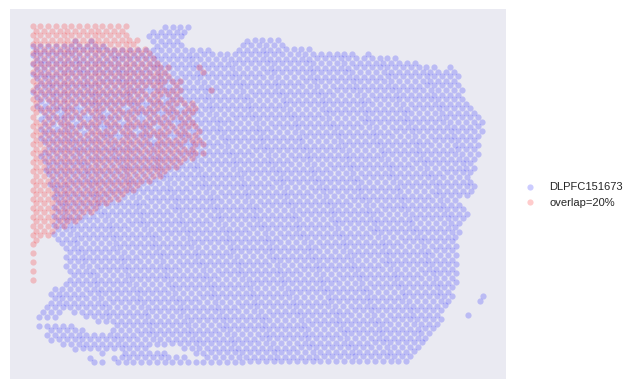

In [62]:
outPut='/home/xiem6/0Projects/Benchmark_STdata/tutorials/'
for slice_name, adata in slices.items():
    p, mm, adata_layer_sim_both_final  = simulate_out(adata, pseudocounts, slice_name, output = outPut)

In [63]:
plt.savefig('spatial.png')

<Figure size 640x480 with 0 Axes>